In [63]:
""" RNN dam flow prediction: stacked RNN """

# import libraries
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Flatten
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt


In [64]:
rain_data = pd.read_csv('rain_day.csv', encoding='utf-8')
dam_data = pd.read_csv('dam_edit.csv', encoding='utf-8')

In [65]:
data = []

In [66]:
dam_data = dam_data.drop('Unnamed: 0', axis = 1)

In [67]:
data = pd.merge( dam_data,rain_data, on='date', how='inner')

In [68]:
data = data.fillna(0)

In [69]:
print(data)

             date  dam_t-1    90  100  101  211  212
0      1974-01-01    0.000   0.0  0.0  0.0  0.0  0.0
1      1974-01-02   10.000   0.0  0.0  0.0  0.0  0.0
2      1974-01-03    9.000   0.0  0.0  0.0  0.0  0.0
3      1974-01-04    4.800   0.0  0.0  0.0  0.0  0.0
4      1974-01-05    6.100   0.0  0.0  0.0  0.0  0.0
...           ...      ...   ...  ...  ...  ...  ...
18257  2023-12-27   30.518   0.0  0.0  0.0  0.0  0.0
18258  2023-12-28   25.873   0.0  0.0  0.0  0.0  0.0
18259  2023-12-29   21.186   0.0  0.0  0.0  0.0  0.0
18260  2023-12-30   20.887   0.7  2.3  9.9  6.8  8.5
18261  2023-12-31   29.183  26.8  6.0  5.3  3.1  4.9

[18262 rows x 7 columns]


In [70]:
print(dam_data)

             date  dam_t-1
0      1974-01-01    0.000
1      1974-01-02   10.000
2      1974-01-03    9.000
3      1974-01-04    4.800
4      1974-01-05    6.100
...           ...      ...
18257  2023-12-27   30.518
18258  2023-12-28   25.873
18259  2023-12-29   21.186
18260  2023-12-30   20.887
18261  2023-12-31   29.183

[18262 rows x 2 columns]


In [71]:
dam = dam_data.drop('date', axis= 1)

In [72]:
print(rain_data)

             date    90  100  101  211  212
0      1974-01-01   0.0  0.0  0.0  0.0  0.0
1      1974-01-02   0.0  0.0  0.0  0.0  0.0
2      1974-01-03   0.0  0.0  0.0  0.0  0.0
3      1974-01-04   0.0  0.0  0.0  0.0  0.0
4      1974-01-05   0.0  0.0  0.0  0.0  0.0
...           ...   ...  ...  ...  ...  ...
18257  2023-12-27   0.0  0.0  0.0  0.0  0.0
18258  2023-12-28   0.0  0.0  0.0  0.0  0.0
18259  2023-12-29   0.0  0.0  0.0  0.0  0.0
18260  2023-12-30   0.7  2.3  9.9  6.8  8.5
18261  2023-12-31  26.8  6.0  5.3  3.1  4.9

[18262 rows x 6 columns]


In [73]:
data = data[9496:]

In [74]:
data

,date,dam_t-1,90,100,101,211,212
9496,2000-01-01,13.000,1.2,1.0,0.0,0.0,0.0
9497,2000-01-02,15.900,1.1,3.1,8.9,7.0,9.0
9498,2000-01-03,20.400,0.0,0.0,0.0,0.0,0.0
9499,2000-01-04,16.000,0.0,0.0,0.0,0.0,0.0
9500,2000-01-05,13.700,10.4,9.1,12.0,5.8,12.0
...,...,...,...,...,...,...,...
18257,2023-12-27,30.518,0.0,0.0,0.0,0.0,0.0
18258,2023-12-28,25.873,0.0,0.0,0.0,0.0,0.0
18259,2023-12-29,21.186,0.0,0.0,0.0,0.0,0.0
18260,2023-12-30,20.887,0.7,2.3,9.9,6.8,8.5


In [75]:
# save original 'Open' prices for later
original_dam = data['dam_t-1'].values

In [76]:
# separate dates for future plotting
dates = pd.to_datetime(data['date'])

In [77]:
print(data)

             date  dam_t-1    90  100   101  211   212
9496   2000-01-01   13.000   1.2  1.0   0.0  0.0   0.0
9497   2000-01-02   15.900   1.1  3.1   8.9  7.0   9.0
9498   2000-01-03   20.400   0.0  0.0   0.0  0.0   0.0
9499   2000-01-04   16.000   0.0  0.0   0.0  0.0   0.0
9500   2000-01-05   13.700  10.4  9.1  12.0  5.8  12.0
...           ...      ...   ...  ...   ...  ...   ...
18257  2023-12-27   30.518   0.0  0.0   0.0  0.0   0.0
18258  2023-12-28   25.873   0.0  0.0   0.0  0.0   0.0
18259  2023-12-29   21.186   0.0  0.0   0.0  0.0   0.0
18260  2023-12-30   20.887   0.7  2.3   9.9  6.8   8.5
18261  2023-12-31   29.183  26.8  6.0   5.3  3.1   4.9

[8766 rows x 7 columns]


In [78]:
# variables for training
cols = list(data)[1:7]

In [79]:
print(cols)

['dam_t-1', '90', '100', '101', '211', '212']


In [80]:
# new dataframe with only training data - 5 columns
data = data[cols].astype(float)

In [81]:
# normalize the dataset
scaler = MinMaxScaler(feature_range = (0,1))
dam_data_scaled = scaler.fit_transform(data)


In [82]:
scaler_dam = MinMaxScaler(feature_range=(0,1))
dam_scaled = scaler_dam.fit_transform(dam)

In [83]:
print(dam_data_scaled)

[[0.00308923 0.00325468 0.00140351 0.         0.         0.        ]
 [0.00377837 0.00298346 0.00435088 0.03390476 0.02777778 0.03522505]
 [0.00484772 0.         0.         0.         0.         0.        ]
 ...
 [0.0050345  0.         0.         0.         0.         0.        ]
 [0.00496344 0.00189856 0.00322807 0.03771429 0.02698413 0.0332681 ]
 [0.00693485 0.07268782 0.00842105 0.02019048 0.01230159 0.01917808]]


In [84]:
# split to train data and test data
n_train = int(0.9*dam_data_scaled.shape[0])
train_data_scaled = dam_data_scaled[0: n_train]
train_dates = dates[0: n_train]

test_data_scaled = dam_data_scaled[n_train:]
test_dates = dates[n_train:]
print(test_dates.head(5))

17385   2021-08-07
17386   2021-08-08
17387   2021-08-09
17388   2021-08-10
17389   2021-08-11
Name: date, dtype: datetime64[ns]


In [85]:
print(train_data_scaled)

[[0.00308923 0.00325468 0.00140351 0.         0.         0.        ]
 [0.00377837 0.00298346 0.00435088 0.03390476 0.02777778 0.03522505]
 [0.00484772 0.         0.         0.         0.         0.        ]
 ...
 [0.00855836 0.         0.         0.         0.         0.        ]
 [0.00594012 0.         0.         0.         0.         0.        ]
 [0.00463028 0.04393816 0.02049123 0.00190476 0.03888889 0.0183953 ]]


In [86]:
# data reformatting for LSTM
pred_days = 1  # prediction period
seq_len = 24   # sequence length = past days for future prediction.
input_dim = 6  # input_dimension = ['dam', '90', '100', '101', '211', '212']

trainX = []
trainY = []
testX = []
testY = []

for i in range(seq_len, n_train-pred_days +1):
    trainX.append(train_data_scaled[i - seq_len:i, 0:train_data_scaled.shape[1]])
    trainY.append(train_data_scaled[i + pred_days - 1:i + pred_days, 0])

for i in range(seq_len, len(test_data_scaled)-pred_days +1):
    testX.append(test_data_scaled[i - seq_len:i, 0:test_data_scaled.shape[1]])
    testY.append(test_data_scaled[i + pred_days - 1:i + pred_days, 0])

print(trainX[0])
print(trainY[0])

trainX, trainY = np.array(trainX), np.array(trainY)
testX, testY = np.array(testX), np.array(testY)

[[0.00308923 0.00325468 0.00140351 0.         0.         0.        ]
 [0.00377837 0.00298346 0.00435088 0.03390476 0.02777778 0.03522505]
 [0.00484772 0.         0.         0.         0.         0.        ]
 [0.00380213 0.         0.         0.         0.         0.        ]
 [0.00325557 0.02820721 0.01277193 0.04571429 0.02301587 0.04696673]
 [0.00520417 0.01627339 0.01136842 0.04609524 0.04325397 0.06457926]
 [0.00727157 0.         0.0002807  0.         0.         0.        ]
 [0.0025902  0.         0.00014035 0.0007619  0.         0.00039139]
 [0.00563191 0.         0.         0.         0.         0.        ]
 [0.00365955 0.         0.         0.00038095 0.00039683 0.        ]
 [0.00441998 0.00054245 0.         0.         0.         0.        ]
 [0.00437245 0.08543531 0.01080702 0.02057143 0.00396825 0.01174168]
 [0.00489524 0.0070518  0.00463158 0.0152381  0.01468254 0.01565558]
 [0.00320805 0.         0.         0.         0.         0.        ]
 [0.00306547 0.         0.        

In [87]:
print(trainX.shape, trainY.shape)
print(testX.shape, testY.shape)

(7865, 24, 6) (7865, 1)
(853, 24, 6) (853, 1)


In [88]:
print(data)

       dam_t-1    90  100   101  211   212
9496    13.000   1.2  1.0   0.0  0.0   0.0
9497    15.900   1.1  3.1   8.9  7.0   9.0
9498    20.400   0.0  0.0   0.0  0.0   0.0
9499    16.000   0.0  0.0   0.0  0.0   0.0
9500    13.700  10.4  9.1  12.0  5.8  12.0
...        ...   ...  ...   ...  ...   ...
18257   30.518   0.0  0.0   0.0  0.0   0.0
18258   25.873   0.0  0.0   0.0  0.0   0.0
18259   21.186   0.0  0.0   0.0  0.0   0.0
18260   20.887   0.7  2.3   9.9  6.8   8.5
18261   29.183  26.8  6.0   5.3  3.1   4.9

[8766 rows x 6 columns]


In [89]:
# RNN model
model = Sequential()
model.add(Flatten(input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dense(64, activation ='relu'))
model.add(Dense(32))
model.add(Dense(trainY.shape[1]))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 144)               0         
                                                                 
 dense_3 (Dense)             (None, 64)                9280      
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total params: 11393 (44.50 KB)
Trainable params: 11393 (44.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [90]:
# specify your learning rate
learning_rate = 0.01
# create an Adam optimizer with the specified learning rate
optimizer = Adam(learning_rate=learning_rate)
# compile your model using the custom optimizer
model.compile(optimizer=optimizer, loss='mse')

No weights found, training model from scratch
Epoch 1/30
222/222 [==============================] - 1s 2ms/step - loss: 5.0764e-04 - val_loss: 5.7095e-04
Epoch 2/30
222/222 [==============================] - 0s 1ms/step - loss: 4.8097e-04 - val_loss: 6.3121e-04
Epoch 3/30
222/222 [==============================] - 0s 1ms/step - loss: 3.6681e-04 - val_loss: 5.7114e-04
Epoch 4/30
222/222 [==============================] - 0s 1ms/step - loss: 3.2296e-04 - val_loss: 6.3489e-04
Epoch 5/30
222/222 [==============================] - 0s 1ms/step - loss: 3.3227e-04 - val_loss: 6.7032e-04
Epoch 6/30
222/222 [==============================] - 0s 1ms/step - loss: 2.8736e-04 - val_loss: 6.8944e-04
Epoch 7/30
222/222 [==============================] - 0s 1ms/step - loss: 2.9272e-04 - val_loss: 6.8588e-04
Epoch 8/30
222/222 [==============================] - 0s 1ms/step - loss: 2.7060e-04 - val_loss: 7.9417e-04
Epoch 9/30
222/222 [==============================] - 0s 1ms/step - loss: 2.5634e-04 - val

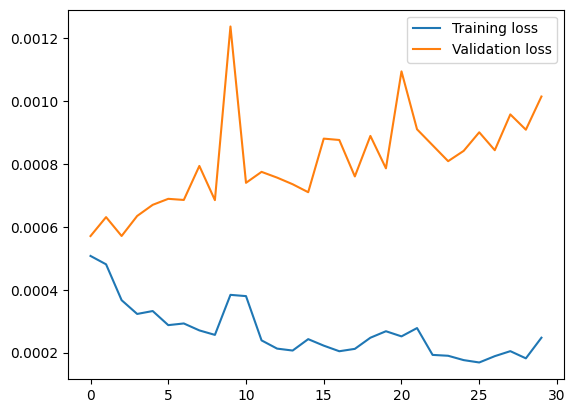

In [96]:
# Try to load weights
try:
    model.load_weights('1dam_rnn_weights.h5')
    print("Loaded model weights from disk")
except:
    print("No weights found, training model from scratch")
    # Fit the model
    history = model.fit(trainX, trainY, epochs=30, batch_size=32,
                    validation_split=0.1, verbose=1)
    # Save model weights after training
    model.save_weights('dam_rnn_weights.h5')

    plt.plot(history.history['loss'], label='Training loss')
    plt.plot(history.history['val_loss'], label='Validation loss')
    plt.legend()
    plt.show()

27/27 [==============================] - 0s 1ms/step
(853,)


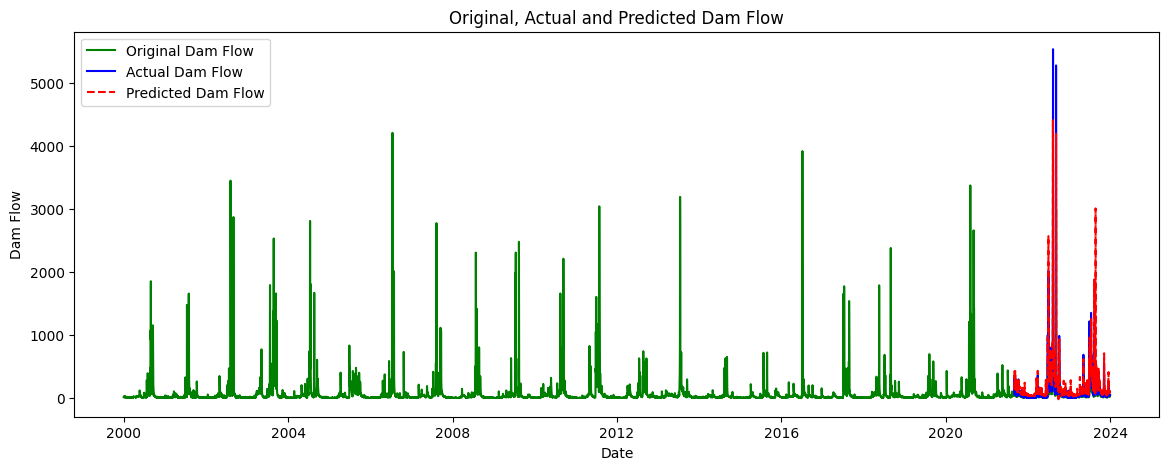

In [97]:
prediction = model.predict(testX)

y_pred = scaler_dam.inverse_transform(prediction)[:,0]

testY_original = scaler_dam.inverse_transform(testY)[:,0]
print(testY_original.shape)

# plotting
plt.figure(figsize=(14, 5))

# plot original 'Open' prices
plt.plot(dates, original_dam, color='green', label='Original Dam Flow')

# plot actual vs predicted
plt.plot(test_dates[seq_len:], testY_original, color='blue', label='Actual Dam Flow')
plt.plot(test_dates[seq_len:], y_pred, color='red', linestyle='--', label='Predicted Dam Flow')
plt.xlabel('Date')
plt.ylabel('Dam Flow')
plt.title('Original, Actual and Predicted Dam Flow')
plt.legend()
plt.show()

In [98]:
testDates = []
for day in test_dates[24:]:
  testDates.append(day.strftime("%Y-%m-%d"))

testDates = pd.DataFrame(testDates)
pred_y = pd.DataFrame(y_pred)
original_y = pd.DataFrame(testY_original)

rnn_include_dam = pd.concat([testDates, original_y, pred_y], axis = 1)
print(rnn_include_dam)

rnn_include_dam = pd.DataFrame(rnn_include_dam)
rnn_include_dam.to_csv("./data/rnn_include_dam.csv")

              0           0           0
0    2021-08-31   57.317210  131.366714
1    2021-09-01   77.403751  221.714523
2    2021-09-02  359.333328  420.540802
3    2021-09-03  320.865508  407.386963
4    2021-09-04  189.961588  284.460205
..          ...         ...         ...
848  2023-12-27   53.706067  104.123657
849  2023-12-28   45.531722  109.538803
850  2023-12-29   37.283464   88.567886
851  2023-12-30   36.757279   94.502892
852  2023-12-31   51.356713  112.653870

[853 rows x 3 columns]


In [99]:
testX_last = []

for x in testX:
  testX_last.append(x[-1])

print(testX_last[0])

testX_last = scaler.inverse_transform(testX_last)
testX_last = pd.DataFrame(testX_last)

rnn_include_x = pd.concat([testDates, testX_last, original_y, pred_y], axis = 1)
rnn_include_x.to_csv("./data/rnn_include_x.csv")

print(rnn_include_x)

[0.00908876 0.         0.         0.         0.         0.        ]
              0        0     1     2     3     4     5           0           0
0    2021-08-31   38.247   0.0   0.0   0.0   0.0   0.0   57.317210  131.366714
1    2021-09-01   32.570  20.2  34.5  34.8  30.2  56.4   77.403751  221.714523
2    2021-09-02   43.984  30.6  69.0   7.5  10.2  30.6  359.333328  420.540802
3    2021-09-03  204.188   0.0   0.1   0.1   0.0   0.0  320.865508  407.386963
4    2021-09-04  182.329   0.0   0.0   0.0   0.0   0.0  189.961588  284.460205
..          ...      ...   ...   ...   ...   ...   ...         ...         ...
848  2023-12-27   25.785   0.0   0.0   0.0   0.0   0.0   53.706067  104.123657
849  2023-12-28   30.518   0.0   0.0   0.0   0.0   0.0   45.531722  109.538803
850  2023-12-29   25.873   0.0   0.0   0.0   0.0   0.0   37.283464   88.567886
851  2023-12-30   21.186   0.0   0.0   0.0   0.0   0.0   36.757279   94.502892
852  2023-12-31   20.887   0.7   2.3   9.9   6.8   8.5   51.356

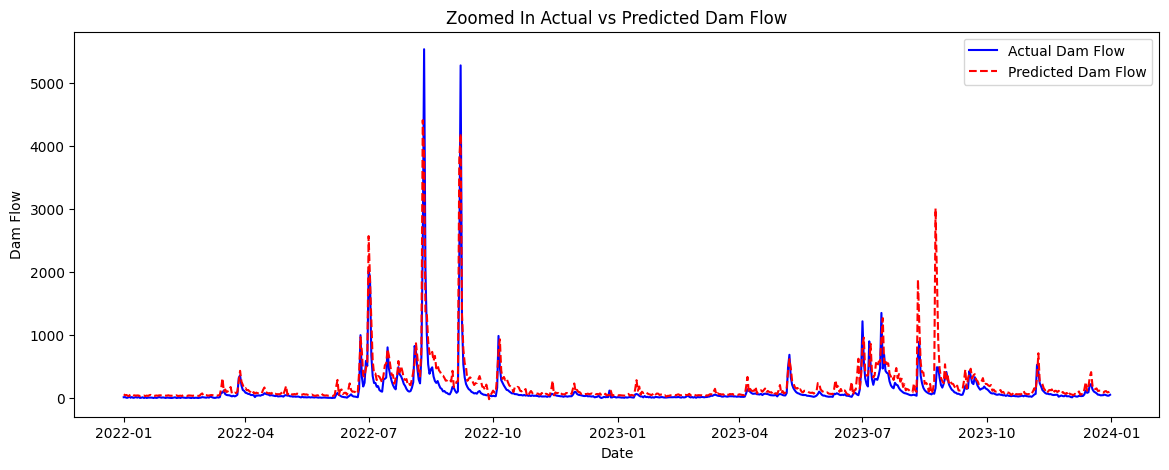

In [102]:
# Calculate the start and end indices for the zoomed plot
zoom_start = len(test_dates) - 365*2
zoom_end = len(test_dates)

# Create the zoomed plot
plt.figure(figsize=(14, 5))

# Adjust the start index for the testY_original and y_pred arrays
adjusted_start = zoom_start - seq_len

plt.plot(test_dates[zoom_start:zoom_end],
         testY_original[adjusted_start:zoom_end - zoom_start + adjusted_start],
         color='blue',
         label='Actual Dam Flow')

plt.plot(test_dates[zoom_start:zoom_end],
         y_pred[adjusted_start:zoom_end - zoom_start + adjusted_start ],
         color='red',
         linestyle='--',
         label='Predicted Dam Flow')

plt.xlabel('Date')
plt.ylabel('Dam Flow')
plt.title('Zoomed In Actual vs Predicted Dam Flow')
plt.legend()
plt.show()

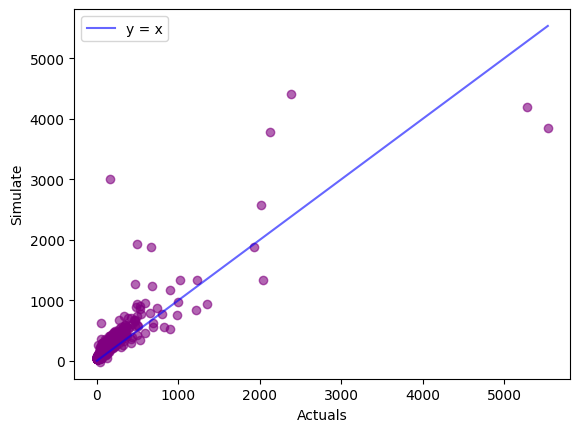

In [103]:
# 일대일 그래프
x = np.arange(0,max(max(testY_original), max(y_pred)))
y = x
plt.scatter(testY_original[:], y_pred[:], color = 'purple', alpha = 0.6)
plt.plot(x,y, color = 'blue', alpha = 0.6, label = 'y = x')
plt.xlabel('Actuals')
plt.ylabel('Simulate')

plt.legend()
plt.show()

In [104]:
#RMSE
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

rmse = np.sqrt(mean_squared_error(testY_original, y_pred))
print('RMSE : %.2f' %(rmse))

RMSE : 197.15


In [105]:
# NSE
from numpy import mean
num_sum1 = 0
num_sum2 = 0
num_avg = mean(testY_original[:])
for i in range(len(testY_original)):
  num1 = testY_original[i] - y_pred[i]
  num_sum1 += num1**2
  num2 = testY_original[i] - num_avg
  num_sum2 += num2**2

nse = 1 - (num_sum1 / num_sum2)
print('NSE : %f' %nse)

NSE : 0.655929


In [106]:
# PBIAS
num_sum1 = 0
for i in range(len(testY_original)):
  num1 = testY_original[i] - y_pred[i]
  num_sum1 += num1

pbias = (num_sum1 / np.sum(testY_original[:])) * 100
print('PBIAS : %f' %pbias)

PBIAS : -64.203473


In [107]:
#R^2
import math

num_sum1 = 0
num_sum2 = 0
num_sum3 = 0
act_avg = mean(testY_original[:])
pred_avg = mean(y_pred[:])
for i in range(len(testY_original)):
  num1 = (testY_original[i] - act_avg) * (y_pred[i] - pred_avg)
  num_sum1 += num1
  num2 = testY_original[i] - pred_avg
  num_sum2 += num2**2
  num3 = y_pred[i] - pred_avg
  num_sum3 += num3**2

r_square = (num_sum1 / (math.sqrt(num_sum2)* math.sqrt(num_sum3)))**2
print('R Square : %f' %r_square)

R Square : 0.716004
